In [6]:
#Lê um arquivo csv com a descrição do dataset e separa em 3, pra treinamento, validação e teste

import csv
from random import shuffle,seed

genlist = []

with open("dataset.csv", "r") as f:
	reader = csv.reader(f)
	i = 0
	for line in reader:
		if i > 0:
			genlist.append(line) 
		else:
			header = line
		i+=1

f.close()

seed()
for i in range(4):
	shuffle(genlist)
size = len(genlist)
i = 0

markings = open('test.csv','w', encoding="utf-8")
writer = csv.writer(markings)
writer.writerow(header)

j = 0
while j < int(0.1*size):					#10% para teste
	writer.writerow(genlist[i])
	i+=1
	j+=1

markings.close()

markings = open('validation.csv','w', encoding="utf-8")
writer = csv.writer(markings)
writer.writerow(header)

j = 0
while j < int(0.1*size):					#10% para validacao
	writer.writerow(genlist[i])
	i+=1
	j+=1

markings.close()

markings = open('train.csv','w', encoding="utf-8")
writer = csv.writer(markings)
writer.writerow(header)

while i < size:
	writer.writerow(genlist[i])				#80% para treino
	i+=1

markings.close()

Found 89696 validated image filenames.
Found 11212 validated image filenames.
[0.92722461 1.08517228]
Epoch 1/400
128/128 [==============================] - 164s 1s/step - loss: 158.7849 - accuracy: 0.4922 - val_loss: 97.3734 - val_accuracy: 0.4677 - lr: 0.0010
Epoch 2/400
128/128 [==============================] - 147s 1s/step - loss: 69.1429 - accuracy: 0.5210 - val_loss: 47.5150 - val_accuracy: 0.5337 - lr: 0.0010
Epoch 3/400
128/128 [==============================] - 144s 1s/step - loss: 35.2319 - accuracy: 0.5010 - val_loss: 25.4836 - val_accuracy: 0.4663 - lr: 0.0010
Epoch 4/400
128/128 [==============================] - 142s 1s/step - loss: 19.7332 - accuracy: 0.4966 - val_loss: 14.9950 - val_accuracy: 0.5337 - lr: 0.0010
Epoch 5/400
128/128 [==============================] - 143s 1s/step - loss: 12.3397 - accuracy: 0.5044 - val_loss: 10.2064 - val_accuracy: 0.5337 - lr: 0.0010
Epoch 6/400
128/128 [==============================] - 143s 1s/step - loss: 8.8977 - accuracy: 0.5029 

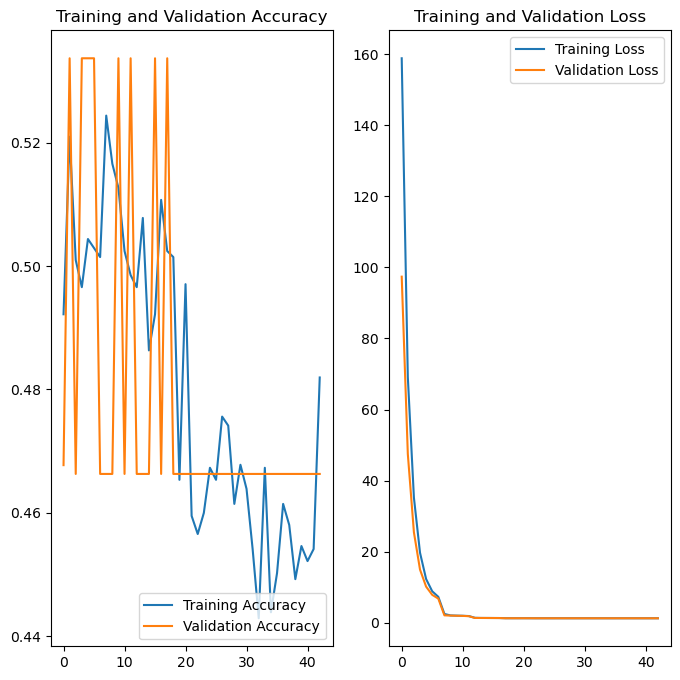

In [5]:
#Treina uma CNN, possui várias opções de backbone pra usar. Recomendo começar pela MobileNet. Usa os arquivos CSV criados anteriormente

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from tensorflow.keras.optimizers import RMSprop
from  keras.layers import Input
import pandas as pd
from math import log
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from tensorflow.compat.v1 import InteractiveSession
from tensorflow.keras.regularizers import l1,l2

os.environ['CUDA_VISIBLE_DEVICES']="0"
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, 'Not enough GPU hardware devices available'

train_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

train_annot = pd.read_csv('train.csv',header=0)
y_train = train_annot['Findings']
test_annot = pd.read_csv('validation.csv',header=0)

train_generator = train_datagen.flow_from_dataframe(dataframe=train_annot,directory='dataset', class_mode='raw', x_col='Image Index', y_col="Findings",
													target_size=(320,320), batch_size=16, color_mode='grayscale')

#color_mode='grayscale'

test_generator = test_datagen.flow_from_dataframe(dataframe=test_annot,directory='dataset', class_mode='raw', x_col='Image Index', y_col='Findings',
													target_size=(320, 320), batch_size=16, color_mode='grayscale')


inn = layers.Input(shape=(320,320,1))
# x = layers.experimental.preprocessing.Rescaling(1./255.)(inn)

VGG16 = tf.keras.applications.vgg16.VGG16(
	include_top=False, weights= None, input_tensor=inn,
)
backbone = VGG16

#MOBILENET = tf.keras.applications.mobilenet.MobileNet(
#	include_top=False, weights='imagenet', input_tensor=inn,
#)
#backbone = MOBILENET

#MOBILENETv2 = tf.keras.applications.mobilenet_v2.MobileNetV2(
#	include_top=False, weights='imagenet', input_tensor=inn,
#)
#backbone = MOBILENETv2

#MOBILENETv3 = tf.keras.applications.MobileNetV3Small(
#	include_top=False, weights='imagenet', input_tensor=inn,
#)
#backbone = MOBILENETv3

#DENSENET = tf.keras.applications.densenet.DenseNet121(
#	include_top=False, weights= None, input_tensor=inn,
#)
#backbone = DENSENET

#RESNET50 = tf.keras.applications.resnet50.ResNet50(
#    include_top=False, weights='imagenet',input_tensor=inn
#)
#backbone = RESNET50

#RESNET101 = tf.keras.applications.resnet.ResNet101(
#    include_top=False, weights='imagenet',input_tensor=inn
#)
#backbone = RESNET101

# NasNetMobile = tf.keras.applications.nasnet.NASNetMobile(
#     include_top=False, weights='imagenet',input_tensor=inn,
# )
# backbone = NasNetMobile

#EFFICIENTNET = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(
#    include_top=False, weights='imagenet',input_tensor=inn,
#)
#backbone = EFFICIENTNET

#xception = tf.keras.applications.xception.Xception(
#    include_top=False, weights='imagenet',input_tensor=inn,
#)
#backbone = xception    


#backbone.trainable = False
backbone.trainable = True

#x = layers.Conv2D(96, (11, 11), activation='relu')(inn) 	#Adiciona camada de convoluçao
#x = layers.MaxPooling2D((2, 2))(x)							#Adiciona a camada de pooling
#x = layers.Conv2D(256, (5, 5), activation='relu')(x)
#x = layers.MaxPooling2D((2, 2))(x)
#x = layers.Conv2D(384, (3, 3), activation='relu')(x)
#x = layers.MaxPooling2D((2, 2))(x)
#x = layers.Flatten()(x)										#Converte a estrutura de dados 2D da camada anterior em uma estrutura 1D, vetor
x = layers.Flatten()(backbone.layers[-1].output)
#x = layers.BatchNormalization()(x)
#x = layers.Dropout(0.1)(x)
# x = layers.Dense(1024,activation='linear',kernel_regularizer=l2(0.01))(x)
# x = layers.BatchNormalization()(x)
#x = layers.Dense(1024,activation='linear',kernel_regularizer=l2(0.01))(x)
#x = layers.BatchNormalization()(x)
#x = layers.Dropout(0.1)(x)
x = layers.Dense(128,activation='linear',kernel_regularizer=l1(0.01))(x)
# x = layers.BatchNormalization()(x)
# x = layers.Dropout(0.3)(x)
o = layers.Dense(10,activation='softmax',kernel_regularizer=l1(0.01))(x)

#------------ ALEXNET -----------------

# 1st Convolutional Layer
#x = layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', weights=None)(inn)
#x = layers.MaxPooling2D(pool_size=(3,3), strides=(2,2))(x)
#x = layers.BatchNormalization()(x)

# 2nd Convolutional Layer
#x = layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding="same", activation='relu', weights=None)(x)
#x = layers.MaxPooling2D(pool_size=(3,3), strides=(2,2))(x)
#x = layers.BatchNormalization()(x)

# 3rd Convolutional Layer
#x = layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding="same", activation='relu', weights=None)(x)
#x = layers.BatchNormalization()(x)

# 4th Convolutional Layer
#x = layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding="same", activation='relu', weights=None)(x)
#x = layers.BatchNormalization()(x)

# 5th Convolutional Layer
#x = layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding="same", activation='relu', weights=None)(x)
#x = layers.MaxPooling2D(pool_size=(3,3), strides=(2,2))(x)
#x = layers.BatchNormalization()(x)

# Flatten Layer
#x = layers.Flatten()(x)

# 1st Dense Layer
#x = layers.Dense(units=4096, activation='relu')(x)
#x = layers.Dropout(rate=0.5)(x)
#x = layers.BatchNormalization()(x)

# 2nd Dense Layer
#x = layers.Dense(units=4096, activation='relu')(x)
#x = layers.Dropout(rate=0.5)(x)
#x = layers.BatchNormalization()(x)

# 3rd Dense Layer
#x = layers.Dense(units=128, activation='relu')(x)
#x = layers.Dropout(rate=0.5)(x)
#x = layers.BatchNormalization()(x)

# Output Layer
#o = layers.Dense(units=10, activation='softmax')(x)


class_weights = compute_class_weight('balanced',classes=np.unique(y_train),y=y_train)
# for i in range(len(class_weights)):
#	class_weights[i] = class_weights[i]**0.5
# 	class_weights[i] = min(class_weights[i],20)
# 	# class_weights[i] = max(class_weights[i],0.6)
# class_weights = np.insert(class_weights,3,0.0)
# class_weights[0] = .4
# class_weights[1] = 1.2
# class_weights[2] = 2.4
# class_weights[3] = 3.6
# class_weights[4] = 4.8
# class_weights[5] = 6.0
# class_weights[6] = 7
# class_weights[7] = 7
# class_weights[8] = 7
# class_weights[9] = 8
print(class_weights)
class_weight_dict = dict(enumerate(class_weights))

model = tf.keras.Model(inputs=inn,outputs=[o])


# model.summary()
# model.load_weights('cnn_model.h5')

num_epochs = 400
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)			#Usa o otimizador Adam para compilar os dados padrao 10^-3
model.compile(optimizer=optimizer,									#Complila a rede
				loss=tf.keras.losses.SparseCategoricalCrossentropy(),
				metrics = ['accuracy'])

reduce_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(			#Reduz learning rate baseado na accuracy dadas x epocas
        monitor  = 'val_loss',
        factor   = 0.1,
        patience = 5,
        verbose  = 0,
        mode     = 'min',
        min_delta  = 0.001,
        cooldown = 0,
        min_lr   = 0
    )

history = model.fit(train_generator,
		validation_data=test_generator,
		steps_per_epoch=128,
		epochs = num_epochs,
		# validation_steps = 64,
		class_weight=class_weight_dict,
		verbose = 1,
		callbacks=[
		# tf.keras.callbacks.LearningRateScheduler(
		# 	lambda epoch: 0.0001/((epoch+1)**0.5)
		# ),
		tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=15,mode = 'min', min_delta=0.001,restore_best_weights=True),
		reduce_on_plateau
	])

model.save('cnn_model.h5')

model.evaluate(test_generator)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss') 
plt.show()


In [ ]:
import re

s = """

"""

# Divide a string em linhas
lines = s.split("\n")

# Inicializa a lista de tempos
times = []

# Procura todas as linhas que contêm a palavra "step" e extrai o tempo correspondente
for line in lines:
    if "step" in line:
        pattern = r"\d+s"
        result = re.findall(pattern, line)[0]
        times.append(result)

# Imprime a lista de tempos
print(" ".join(times))
